# Analysis
This notebook contains exploratory data analysis and plots to asses GAN performance.

## Packages

In [1]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd

# models 
import tensorflow as tf
print(tf.__version__)
tf.disable_eager_execution()
#tf.enable_eager_execution()

# must be True
print(tf.executing_eagerly())

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

import helper_functions as hf
from skimage.metrics import structural_similarity as ssim

import importlib as imp

1.13.1
False


In [573]:
imp.reload(hf)

<module 'helper_functions' from 'C:\\Users\\SWFva\\OneDrive\\Documents\\Studie\\Thesis\\code\\helper_functions.py'>

## Reading data

Data is from two sources NCEP and WRF. WRF is at two different resolutions, 3km and 9km. NCEP is originally at natice resolution 0.25 degree but use interpolated to 18km.

In [14]:
# TRAIN

# WRF 3km
T_WRF_3km = np.load('data/analysis/T_WRF_3km.npy')
U_WRF_3km = np.load('data/analysis/U_WRF_3km.npy')
V_WRF_3km = np.load('data/analysis/V_WRF_3km.npy')

# WRF 9km
T_WRF_9km = np.load('data/analysis/T_WRF_9km.npy')
U_WRF_9km = np.load('data/analysis/U_WRF_9km.npy')
V_WRF_9km = np.load('data/analysis/V_WRF_9km.npy')

# NCEP
T_NCEP_near = np.load('data/analysis/T_NCEP_near.npy')
U_NCEP_near = np.load('data/analysis/U_NCEP_near.npy')
V_NCEP_near = np.load('data/analysis/V_NCEP_near.npy')

# NCEP
T_NCEP_down = np.load('data/analysis/T_NCEP_down.npy')
U_NCEP_down = np.load('data/analysis/U_NCEP_down.npy')
V_NCEP_down = np.load('data/analysis/V_NCEP_down.npy')

In [15]:
# TEST

# WRF 3km
T_WRF_3km_test = np.load('data/analysis/T_WRF_3km_test.npy')
U_WRF_3km_test = np.load('data/analysis/U_WRF_3km_test.npy')
V_WRF_3km_test = np.load('data/analysis/V_WRF_3km_test.npy')

# WRF 9km
T_WRF_9km_test = np.load('data/analysis/T_WRF_9km_test.npy')
U_WRF_9km_test = np.load('data/analysis/U_WRF_9km_test.npy')
V_WRF_9km_test = np.load('data/analysis/V_WRF_9km_test.npy')

# NCEP down
T_NCEP_test = np.load('data/analysis/T_NCEP_test_down.npy')
U_NCEP_test = np.load('data/analysis/U_NCEP_test_down.npy')
V_NCEP_test = np.load('data/analysis/V_NCEP_test_down.npy')

Bicubic interpolation, as a control downscaling technique.

In [597]:
T_bicubic = hf.regrid(hf.downscale_image(T_NCEP_down, K=1/3),2)
U_bicubic = hf.regrid(hf.downscale_image(U_NCEP_down, K=1/3),2)
V_bicubic = hf.regrid(hf.downscale_image(V_NCEP_down, K=1/3),2)

In [598]:
T_bicubic_test = hf.regrid(hf.downscale_image(T_NCEP_test, K=1/3),2)
U_bicubic_test = hf.regrid(hf.downscale_image(U_NCEP_test, K=1/3),2)
V_bicubic_test = hf.regrid(hf.downscale_image(V_NCEP_test, K=1/3),2)

## Exploratory Data Analysis

#### Plot style

In [20]:
import matplotlib as mpl
import matplotlib.colors as mcol

# fontsize
fs = 20

# colormaps
cmap = plt.cm.Spectral  # define the colormap

# define the bins and normalize
# Temperature
T_bounds = range(250,320,1)
T_norm = mcol.BoundaryNorm(T_bounds,cmap.N)

# Wind
W_bounds = range(-40,40,2)
W_norm = mcol.BoundaryNorm(W_bounds,cmap.N)



#### Mu_sig distributions

In [498]:
print(np.mean(T_NCEP_near),np.std(T_NCEP_near))
print(np.mean(T_WRF_9km),np.std(T_WRF_9km))
print('\n')
print(np.mean(T_NCEP_test),np.std(T_NCEP_test))
print(np.mean(T_WRF_9km_test),np.std(T_WRF_9km_test))

280.1292 10.076586
279.676 9.991659


281.00958 9.822044
280.26376 10.129467


In [606]:
print(np.mean(U_NCEP_near),np.std(U_NCEP_near))
print(np.mean(U_WRF_9km),np.std(U_WRF_9km))
print('\n')
print(np.mean(U_NCEP_test),np.std(U_NCEP_test))
print(np.mean(U_WRF_9km_test),np.std(U_WRF_9km_test))

-0.109662965 1.5053785
0.38323697 2.9585693


-0.17021291 1.5913239
0.39394137 2.9028187


In [608]:
print(np.mean(V_NCEP_near),np.std(V_NCEP_near))
print(np.mean(V_WRF_9km),np.std(V_WRF_9km))
print(np.mean(V_WRF_3km),np.std(V_WRF_3km))
print('\n')
print(np.mean(V_NCEP_test),np.std(V_NCEP_test))
print(np.mean(V_WRF_9km_test),np.std(V_WRF_9km_test))

-0.14309347 1.9295136
-0.36844945 3.699887
-0.19180799 3.2436538


-0.19647746 1.8526103
-0.30032504 3.6288803


### RMSE and SSIM
RMSE is the root-mean squared error and will tell about the absolute error between two datasets. SSIM is the structural similarity index measure and will tell about how much the datasets look similar based on their structure. Of course RMSE and SSIM are correlated to a certain degree, but it is possible to keep RMSE constant and vary SSIM.

For deeper understanding we look into these performance measures over time and space.

In [752]:
T_rms_NCEP_downv9km, T_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(T_NCEP_down,6), T_WRF_9km, 'array')
U_rms_NCEP_downv9km, U_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(U_NCEP_down,6), U_WRF_9km, 'array')
V_rms_NCEP_downv9km, V_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(V_NCEP_down,6), V_WRF_9km, 'array')

T_rms_NCEP_downv3km, T_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(T_NCEP_down,6), T_WRF_3km, 'array')
U_rms_NCEP_downv3km, U_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(U_NCEP_down,6), U_WRF_3km, 'array')
V_rms_NCEP_downv3km, V_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(V_NCEP_down,6), V_WRF_3km, 'array')

In [612]:
T_rms_NCEP_testv9km, T_ssim_NCEP_testv9km = hf.performance_dataset(hf.regrid(T_NCEP_test,6), T_WRF_9km, 'array')
U_rms_NCEP_testv9km, U_ssim_NCEP_testv9km = hf.performance_dataset(hf.regrid(U_NCEP_test,6), T_WRF_9km, 'array')
V_rms_NCEP_testv9km, V_ssim_NCEP_testv9km = hf.performance_dataset(hf.regrid(V_NCEP_test,6), T_WRF_9km, 'array')

In [599]:
T_rms_bicubicv9km, T_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(T_bicubic), T_WRF_9km, 'array')
U_rms_bicubicv9km, U_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(U_bicubic), U_WRF_9km, 'array')
V_rms_bicubicv9km, V_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(V_bicubic), V_WRF_9km, 'array')

In [600]:
T_rms_bicubic_testv9km, T_ssim_bicubicv_test9km = hf.performance_dataset(np.squeeze(T_bicubic_test), T_WRF_9km_test, 'array')
U_rms_bicubic_testv9km, U_ssim_bicubicv_test9km = hf.performance_dataset(np.squeeze(U_bicubic_test), U_WRF_9km_test, 'array')
V_rms_bicubic_test9km, V_ssim_bicubicv_test9km = hf.performance_dataset(np.squeeze(V_bicubic_test), V_WRF_9km_test, 'array')

In [ ]:
# RMSE and SSIM per pixel
T_rms_map, T_ssim_map = hf.performance_map(T_WRF_3km,T_NCEP_near)
U_rms_map, U_ssim_map = hf.performance_map(U_WRF_3km,U_NCEP_near)
V_rms_map, V_ssim_map = hf.performance_map(V_WRF_3km,V_NCEP_near)

False


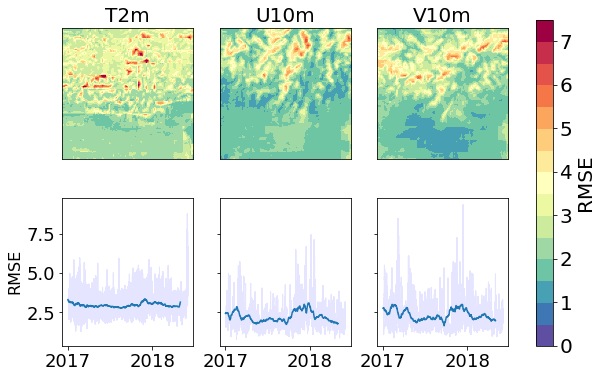

In [787]:
# RMSE
R_bounds = np.arange(0,8,0.5)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)

fig, (axs1,axs2) = plt.subplots(2, 3,figsize=(10,6), sharey='row')

# axes 1
for ax, r, t in zip(axs1.flat,[T_rms_map, U_rms_map, V_rms_map],['T2m','U10m','V10m']):
    
    im =ax.imshow(np.flipud(r),vmin=0, vmax=8, cmap='Spectral_r',norm=R_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t,fontsize=fs)

cb = fig.colorbar(im, ax = (axs1,axs2))
cb.ax.tick_params(labelsize=fs)
cb.set_label(label='RMSE', fontsize = fs)


# --------------axes 2

for ax, r, t in zip(axs2.flat,[T_rms_NCEP_downv3km, U_rms_NCEP_downv3km, V_rms_NCEP_downv3km],['T2m','U10m','V10m']):
    ax.plot(hf.moving_average(r,int(24*30/3)))
    ax.fill_between(range(T_WRF_3km.shape[0]), r, r, color='b', alpha=.1)
    
    ax.tick_params(axis='both', labelsize=fs-2)
    ax.set_xticks([0,2920])
    ax.set_xticklabels(labels=['2017','2018'])

axs2[0].set_ylabel('RMSE', fontsize=16)

#fig.tight_layout()
plt.show()

fig.savefig('figures/RMSE_space_time.pdf',bbox_inches='tight')

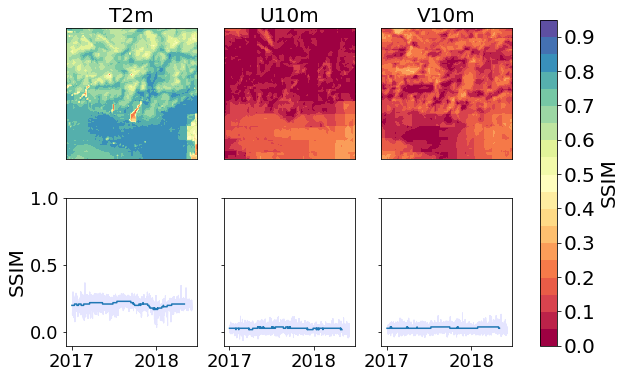

In [1273]:
# SSIM
S_bounds = np.arange(0,1,0.05)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

fig, (axs1,axs2) = plt.subplots(2, 3,figsize=(10,6), sharey='row')

# axes 1

for ax, s, t in zip(axs1.flat,[T_ssim_map, U_ssim_map, V_ssim_map],['T2m','U10m','V10m']):
    
    im =ax.imshow(np.flipud(s),vmin=-0.1, vmax=1,cmap='Spectral',norm=S_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t,fontsize=fs)
    
# --------------axes 2

for ax, s, t in zip(axs2.flat, [T_ssim_NCEP_downv3km, U_ssim_NCEP_downv3km, V_ssim_NCEP_downv3km],['T2m','U10m','V10m']):
    ax.plot(hf.moving_average(s,int(24*30/3)))
    ax.fill_between(range(T_WRF_3km.shape[0]), s, s, color='b', alpha=.1)
    
    ax.tick_params(axis='both', labelsize=fs-2)
    ax.set_xticks([0,2920])
    ax.set_xticklabels(labels=['2017','2018'])
    
    ax.set_ylim(-0.1,1)
    
axs2[0].set_ylabel('SSIM', fontsize=fs)


#fig.tight_layout()

cb = fig.colorbar(im, ax = (axs1,axs2), norm=S_norm)
cb.ax.tick_params(labelsize=fs)
cb.set_label(label='SSIM', fontsize = fs)

plt.show()

fig.savefig('figures/methods/SSIM_space_time.pdf',bbox_inches='tight')

In [15]:
np.round(np.mean(T_ssim_NCEP_downv9km),3), np.round(np.mean(U_ssim_NCEP_downv9km),2),np.round(np.mean(V_ssim_NCEP_downv9km),2)

(0.296, 0.05, 0.06)

### Superresolution problem visualised

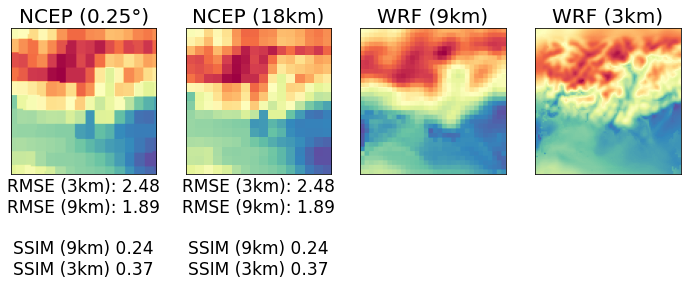

In [14]:
t = 290

fig, axs1 = plt.subplots(1, 4,figsize=(12, 6), sharey = False)

for ax, d, title in zip(axs1.flat,
                        [T_NCEP_near, T_NCEP_down,T_WRF_9km,T_WRF_3km],
                        ['NCEP (0.25\N{DEGREE SIGN})','NCEP (18km)','WRF (9km)', 'WRF (3km)']):
    im = ax.imshow(np.flipud(d[t,:,:]),cmap='Spectral')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=fs)
    if title == 'WRF 9km':
        ax.set_xlabel('RMSE (3km): %.2f\n\nSSIM (3km) %.2f' % (T_rms_9kmv3km[t],T_ssim_9kmv3km[t]), fontsize = fs-3)
    
    if title == 'NCEP (0.25\N{DEGREE SIGN})':
        ax.set_xlabel('RMSE (3km): %.2f\nRMSE (9km): %.2f\n\nSSIM (9km) %.2f\nSSIM (3km) %.2f' % 
                      (T_rms_NCEP_downv3km[t], T_rms_NCEP_downv9km[t],T_ssim_NCEP_downv3km[t], T_ssim_NCEP_downv9km[t]), fontsize = fs-3)
    if title == 'NCEP (18km)':
        ax.set_xlabel('RMSE (3km): %.2f\nRMSE (9km): %.2f\n\nSSIM (9km) %.2f\nSSIM (3km) %.2f' % 
                      (T_rms_NCEP_downv3km[t], T_rms_NCEP_downv9km[t],T_ssim_NCEP_downv3km[t], T_ssim_NCEP_downv9km[t]), fontsize = fs-3)

plt.show()

C:\Users\SWFva\anaconda3\envs\GAN\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SWFva\anaconda3\envs\GAN\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SWFva\anaconda3\envs\GAN\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

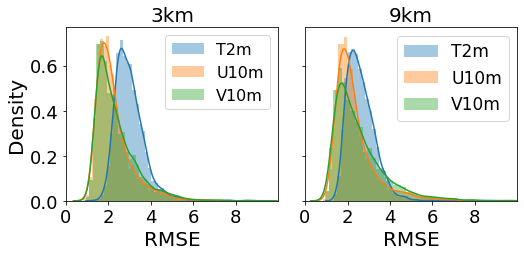

In [1200]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(7,3), sharey='row', sharex='row')
fig.tight_layout()
    
sns.distplot(T_rms_NCEP_downv3km,ax=ax1, label='T2m')
sns.distplot(T_rms_NCEP_downv9km,ax=ax2, label='T2m')

sns.distplot(U_rms_NCEP_downv3km,ax=ax1, label='U10m')
sns.distplot(U_rms_NCEP_downv9km,ax=ax2, label='U10m')

sns.distplot(V_rms_NCEP_downv3km,ax=ax1, label='V10m')
sns.distplot(V_rms_NCEP_downv9km,ax=ax2, label='V10m')


ax1.tick_params(axis='both', labelsize=fs-2)
ax2.tick_params(axis='both', labelsize=fs-2)

ax1.set_title('3km', fontsize=fs)
ax2.set_title('9km', fontsize=fs)

ax1.set_xlabel('RMSE', fontsize=fs)
ax2.set_xlabel('RMSE', fontsize=fs)

ax1.set_xticks(np.arange(0,10,2))
ax1.set_xticklabels(np.arange(0,10,2))

ax1.set_ylabel('Density', fontsize=fs)

ax1.set_xlim(0,10)

ax1.legend(loc='upper right', fontsize=fs-4)
ax2.legend(fontsize=fs-3)

plt.show()
fig.savefig('figures/methods/RMSE_density.pdf', bbox_inches = 'tight')

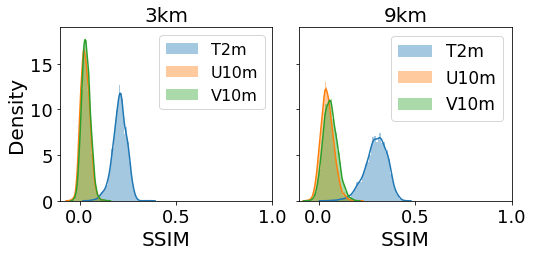

In [37]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(7,3), sharey='row', sharex='row')
fig.tight_layout()
    
sns.distplot(T_ssim_NCEP_downv3km,ax=ax1, label='T2m')
sns.distplot(T_ssim_NCEP_downv9km,ax=ax2, label='T2m')

sns.distplot(U_ssim_NCEP_downv3km,ax=ax1, label='U10m')
sns.distplot(U_ssim_NCEP_downv9km,ax=ax2, label='U10m')

sns.distplot(V_ssim_NCEP_downv3km,ax=ax1, label='V10m')
sns.distplot(V_ssim_NCEP_downv9km,ax=ax2, label='V10m')


ax1.tick_params(axis='both', labelsize=fs-2)
ax2.tick_params(axis='both', labelsize=fs-2)

ax1.set_title('3km', fontsize=fs)
ax2.set_title('9km', fontsize=fs)

ax1.set_xlabel('SSIM', fontsize=fs)
ax2.set_xlabel('SSIM', fontsize=fs)

ax1.set_ylabel('Density', fontsize=fs)

ax1.set_xlim(-0.1,1)
ax2.set_xlim(-0.1,1)

ax1.legend(loc='upper right', fontsize=fs-4)
ax2.legend(fontsize=fs-3)

plt.show()
fig.savefig('figures/methods/SSIM_density.pdf', bbox_inches = 'tight')

## Model performance

### Temperature

In [ ]:
hf.extract_performance(model_path = 'G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned',
                    data_train=T_WRF_9km,
                    data_test=T_WRF_9km_test,
                    minmax = False,
                    max_epoch = 64)

G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00001
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00002
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00003
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00004
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00005
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00006
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00007
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00008
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00009
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00010
G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_learning_rate_tuned/train\cnn00011
G:/Mijn Dr

#### RMSE and SSIM maps and time

In [797]:
# RMSE and SSIM map and timeseries
temp_lr_mr_SR_train = hf.regrid(np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR/train/cnn00037/dataSR.npy'),3)
temp_lr_mr_SR_test = hf.regrid(np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR/test/cnn00037/dataSR.npy'),3)

In [804]:
# map
T_lr_mr_rms_train_map, T_lr_mr_ssim_train_map = hf.performance_map(temp_lr_mr_SR_train,T_WRF_9km)
T_lr_mr_rms_test_map, T_lr_mr_ssim_test_map = hf.performance_map(temp_lr_mr_SR_test,T_WRF_9km_test)

# time
T_lr_mr_rms_train, T_lr_mr_ssim_train = hf.performance_time(temp_lr_mr_SR_train,T_WRF_9km)
T_lr_mr_rms_test, T_lr_mr_ssim_test = hf.performance_time(temp_lr_mr_SR_test,T_WRF_9km_test)

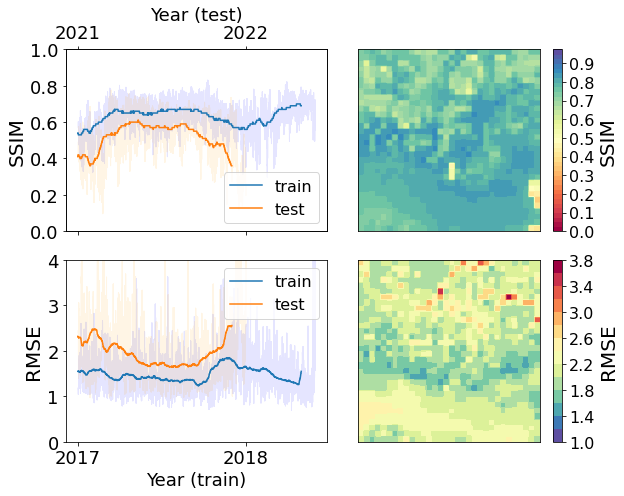

In [1235]:
S_bounds = np.arange(0,1,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(1,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(T_lr_mr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(T_lr_mr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),T_lr_mr_ssim_train, T_lr_mr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(T_lr_mr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),T_lr_mr_ssim_test, T_lr_mr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='lower right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(T_lr_mr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(T_lr_mr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), T_lr_mr_rms_train, T_lr_mr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(T_lr_mr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), T_lr_mr_rms_test, T_lr_mr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE', fontsize = fs)
ax5.legend(loc='upper right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/lr_mr/space_time_T2m.pdf',bbox_inches='tight')

In [842]:
from datetime import datetime, timedelta



def index_to_datetime(index, start_year=2017):
    '''
    Takes the index and returns the datetime
    '''
    days = index/8 
    start = datetime(start_year,1,1,0,0,0)      
    delta = timedelta(days)     
    offset = start + delta      

    return(offset)    




2017-02-11 15:00:00


### Wind

u component

In [604]:
hf.extract_performance(model_path='G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR',
                    data_train=U_WRF_9km,
                    data_test=U_WRF_9km_test,
                    minmax = False,
                    max_epoch = 64)

G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00001
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00002
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00003
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00004
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00005
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00006
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00007
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00008
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00009
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00010
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00011
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00012
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00013
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00014
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\cnn00015
G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train\c

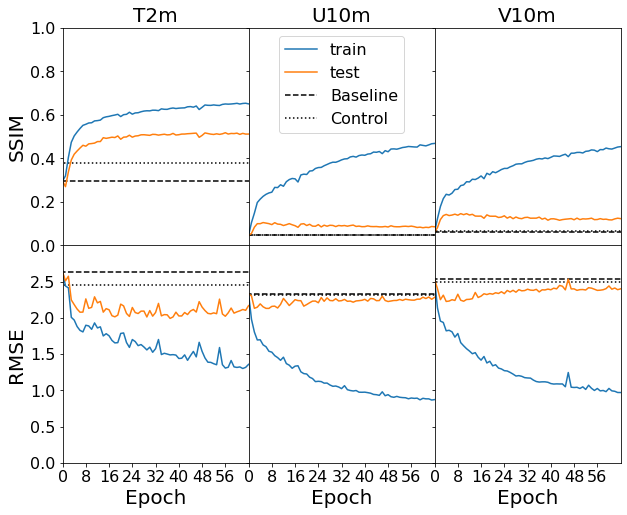

In [1203]:
T_lr_mr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR'+'/performance_df.csv')
U_lr_mr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR'+'/performance_df.csv')
V_lr_mr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR'+'/performance_df_1.csv')


fig, [axs1,axs2] = plt.subplots(2,3,figsize = (10,8), sharex=True, sharey = 'row')


for ax, r, base, control, title in zip(axs1.flat, 
                                       [T_lr_mr_performance_df, U_lr_mr_performance_df, V_lr_mr_performance_df],
                                       [T_ssim_NCEP_downv9km, U_ssim_NCEP_downv9km, V_ssim_NCEP_downv9km],
                                       [T_ssim_bicubicv9km, U_ssim_bicubicv9km, V_ssim_bicubicv9km],
                                       ['T2m','U10m','V10m']):
    # SSIM
    ax.plot([0]+list(r['Epoch']), [np.mean(base)]+list(r['SSIM_train']), label='train')
    ax.plot([0]+list(r['Epoch']), [np.mean(base)]+list(r['SSIM_test']), label='test')

    ax.hlines(np.mean(base),-3,100,linestyles='dashed', label='Baseline')
    ax.hlines(np.mean(control),-1,64,linestyles='dotted', label='Control')
    
    ax.set_title(title,fontsize=fs)

axs1[0].set_ylim(0, 1)
axs1[0].set_xlim(0,64)

axs1[0].set_ylabel('SSIM', fontsize = fs)
axs1[0].tick_params(axis='both', labelsize=fs-4)

axs1[1].legend(loc ='upper center', fontsize = fs-4)



# RMSE

for ax, r, base, control in zip(axs2.flat, 
                       [T_lr_mr_performance_df, U_lr_mr_performance_df, V_lr_mr_performance_df],
                       [T_rms_NCEP_downv9km, U_rms_NCEP_downv9km, V_rms_NCEP_downv9km],
                       [T_rms_bicubicv9km, U_rms_bicubicv9km, V_rms_bicubicv9km]):

    ax.plot([0]+list(r['Epoch']), [np.mean(base)]+list(r['rms_train']), label='train')
    ax.plot([0]+list(r['Epoch']), [np.mean(base)]+list(r['rms_test']), label='test')

    ax.set_ylim(0,3)
    ax.hlines(np.mean(base),-1,64,linestyles='dashed', label='NCEP 18km')
    ax.hlines(np.mean(control),-1,64,linestyles='dotted', label='Bicubic interpolation')
    
    ax.set_xlabel('Epoch', fontsize = fs)
    ax.set_xlim(0,64)


    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks(np.arange(0,64,8))
    ax.set_xticklabels(np.arange(0,72,8))

    ax.set_yticks(np.arange(0,3,0.5))
    ax.set_yticklabels(np.arange(0,3,0.5))
    
axs2[0].set_ylabel('RMSE', fontsize = fs)


plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
plt.show()

fig.savefig('figures/results/lr_mr/epoch.pdf',bbox_inches='tight')

In [1152]:
Wind_SR_train = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/train/cnn00007/dataSR.npy')
Wind_SR_test = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR/test/cnn00007/dataSR.npy')

U_lr_mr_train = hf.regrid(Wind_SR_train[:,:,:,0],3)
U_lr_mr_test = hf.regrid(Wind_SR_test[:,:,:,0],3)

V_lr_mr_train = hf.regrid(Wind_SR_train[:,:,:,1],3)
V_lr_mr_test = hf.regrid(Wind_SR_test[:,:,:,1],3)

# map
U_lr_mr_rms_train_map, U_lr_mr_ssim_train_map = hf.performance_map(U_lr_mr_train,U_WRF_9km)
U_lr_mr_rms_test_map, U_lr_mr_ssim_test_map = hf.performance_map(U_lr_mr_test,U_WRF_9km_test)

V_lr_mr_rms_train_map, V_lr_mr_ssim_train_map = hf.performance_map(V_lr_mr_train,V_WRF_9km)
V_lr_mr_rms_test_map, V_lr_mr_ssim_test_map = hf.performance_map(V_lr_mr_test,V_WRF_9km_test)

# time
U_lr_mr_rms_train, U_lr_mr_ssim_train = hf.performance_time(U_lr_mr_train,U_WRF_9km)
U_lr_mr_rms_test, U_lr_mr_ssim_test = hf.performance_time(U_lr_mr_test,U_WRF_9km_test)

V_lr_mr_rms_train, V_lr_mr_ssim_train = hf.performance_time(V_lr_mr_train,V_WRF_9km)
V_lr_mr_rms_test, V_lr_mr_ssim_test = hf.performance_time(V_lr_mr_test,V_WRF_9km_test)

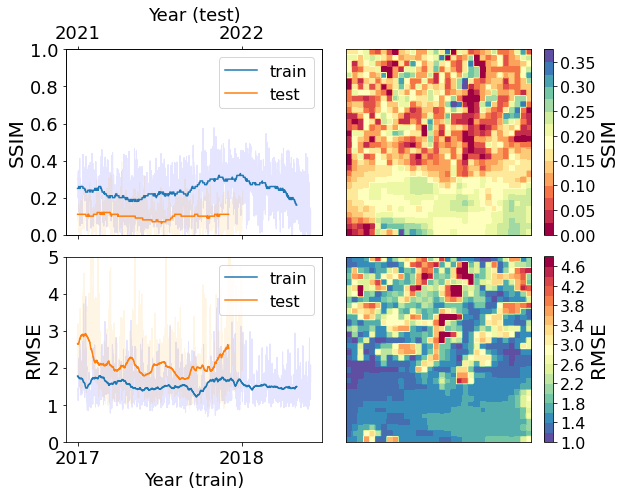

In [1234]:
S_bounds = np.arange(0,0.4,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(1,5,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(U_lr_mr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(U_lr_mr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),U_lr_mr_ssim_train, U_lr_mr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(U_lr_mr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),U_lr_mr_ssim_test, U_lr_mr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(U_lr_mr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(U_lr_mr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), U_lr_mr_rms_train, U_lr_mr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,5)

ax5.plot(hf.moving_average(U_lr_mr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), U_lr_mr_rms_test, U_lr_mr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE', fontsize = fs)
ax5.legend(loc='upper right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/lr_mr/space_time_U10m.pdf',bbox_inches='tight')

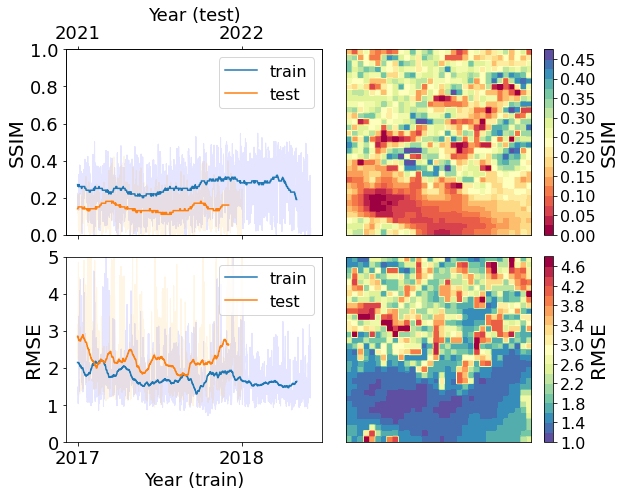

In [1233]:
S_bounds = np.arange(0,0.5,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(1,5,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(V_lr_mr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(V_lr_mr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),V_lr_mr_ssim_train, V_lr_mr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(V_lr_mr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),V_lr_mr_ssim_test, V_lr_mr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(V_lr_mr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(V_lr_mr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), V_lr_mr_rms_train, V_lr_mr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,5)

ax5.plot(hf.moving_average(V_lr_mr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), V_lr_mr_rms_test, V_lr_mr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE', fontsize = fs)
ax5.legend(loc='upper right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/lr_mr/space_time_V10m.pdf',bbox_inches='tight')

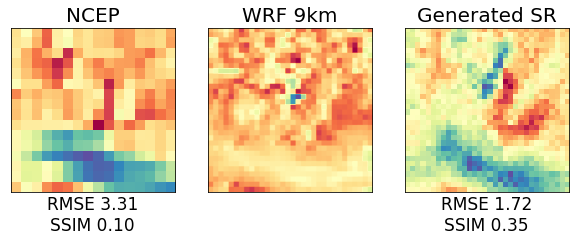

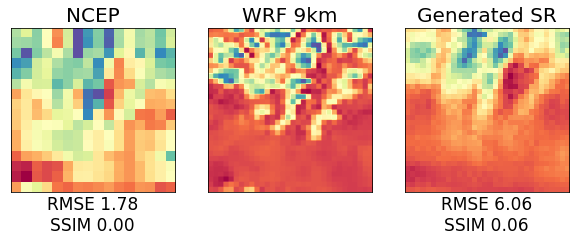

In [794]:
# BEST
t = list(U_rms_test).index(min(U_rms_test))

fig, axs = plt.subplots(1, 3,figsize=(10,10))

axs[0].imshow(np.flipud(U_NCEP_test[t,:,:,0]), cmap='Spectral')
axs[0].set_title('NCEP', fontsize = fs)
axs[0].set_xlabel('RMSE %.2f\nSSIM %.2f' % (U_rms_NCEP_downv9km[t],U_ssim_NCEP_downv9km[t]), fontsize = fs-3)

axs[1].imshow(np.flipud(U_WRF_9km_test[t,:,:]), cmap='Spectral')
axs[1].set_title('WRF 9km', fontsize = fs)

axs[2].imshow(np.flipud(Wind_SR_test[t,:,:,0]), cmap='Spectral')
axs[2].set_title('Generated SR', fontsize = fs)
axs[2].set_xlabel('RMSE %.2f\nSSIM %.2f' % (U_rms_train[t], U_ssim_train[t]), fontsize=fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

t = list(U_rms_test).index(max(U_rms_test))


# WORST

fig, axs = plt.subplots(1, 3,figsize=(10,10))

axs[0].imshow(np.flipud(U_NCEP_test[t,:,:,0]), cmap='Spectral')
axs[0].set_title('NCEP', fontsize = fs)
axs[0].set_xlabel('RMSE %.2f\nSSIM %.2f' % (U_rms_NCEP_downv9km[t],U_ssim_NCEP_downv9km[t]), fontsize = fs-3)

axs[1].imshow(np.flipud(U_WRF_9km_test[t,:,:]), cmap='Spectral')
axs[1].set_title('WRF 9km', fontsize = fs)

axs[2].imshow(np.flipud(Wind_SR_test[t,:,:,0]), cmap='Spectral')
axs[2].set_title('Generated SR', fontsize = fs)
axs[2].set_xlabel('RMSE %.2f\nSSIM %.2f' % (U_rms_test[t], U_ssim_test[t]), fontsize=fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Hyperparameter tuning

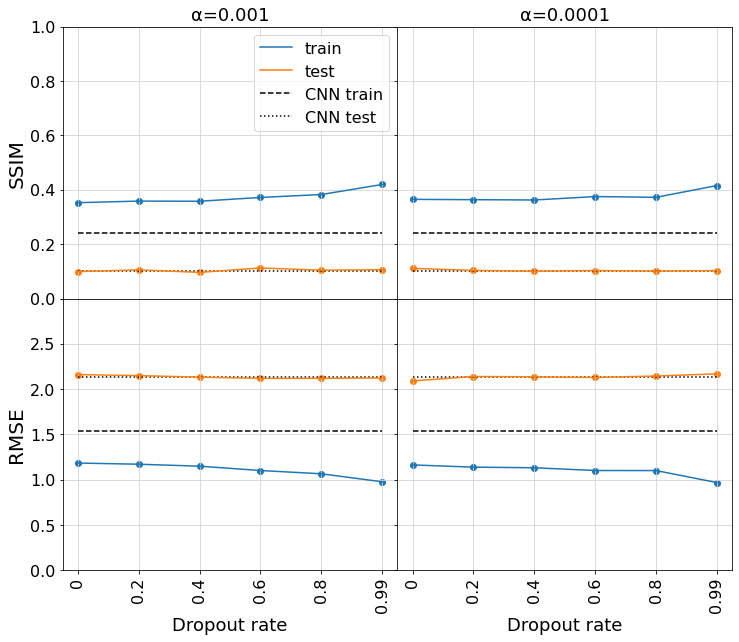

In [1206]:
fig, (axs1,axs) = plt.subplots(2,2,figsize = (12,10),sharex=True, sharey='row')


alphas = [0.001, 0.0001]
dropout_rates = [0,0.2, 0.4, 0.6, 0.8,0.99]

a_id = 0
for a in alphas:
    train_rms = []
    test_rms = []
    train_ssim = []
    test_ssim = []

    d_id = 0
    for d in dropout_rates:
        perf_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR_grid_search/'+'alpha' + str(a) + '_dropout' + str(d)+'/performance_df.csv')
        
        train_rms.append(min(perf_df['rms_train']))    
        test_rms.append(min(perf_df['rms_test']))
        train_ssim.append(max(perf_df['SSIM_train']))    
        test_ssim.append(max(perf_df['SSIM_test']))
        
        d_id += 1
    axs[a_id].grid(color='lightgray')
    axs[a_id].scatter(range(6),train_rms)
    axs[a_id].scatter(range(6),test_rms)
    axs[a_id].plot(range(6),train_rms, label='train')
    axs[a_id].plot(range(6),test_rms, label='test')
    axs[a_id].set_ylim(0,3)

    axs[a_id].set_xlabel('Dropout rate', fontsize=fs-2)
    
    
    axs[a_id].hlines(U_lr_mr_performance_df['rms_train'][6],0,5,linestyles='dashed', label='CNN train')
    axs[a_id].hlines(U_lr_mr_performance_df['rms_test'][6],0,5,linestyles='dotted', label='CNN test')
    
    axs[a_id].set_yticklabels(np.arange(0,3,0.5))
    
    axs[a_id].tick_params(axis='both', labelsize=fs-4)
    axs[a_id].set_xticks(range(6))
    axs[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    axs1[a_id].grid(color='lightgray')
    axs1[a_id].scatter(range(6),train_ssim)
    axs1[a_id].scatter(range(6),test_ssim)
    axs1[a_id].plot(range(6),train_ssim, label='train')
    axs1[a_id].plot(range(6),test_ssim, label='test')
    
    axs1[a_id].set_ylim(0,1)
    
    
    axs1[a_id].hlines(U_lr_mr_performance_df['SSIM_train'][6],0,5,linestyles='dashed', label='CNN train')
    axs1[a_id].hlines(U_lr_mr_performance_df['SSIM_test'][6],0,5,linestyles='dotted', label='CNN test')
    
    axs1[a_id].tick_params(axis='both', labelsize=fs-4)
    axs1[a_id].set_xticks(range(6))
    axs1[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    
    axs1[a_id].set_title('\u03B1='+str(a), fontsize=fs-2)
    
    a_id += 1
    
axs[0].set_ylabel('RMSE', fontsize=fs)
axs1[0].set_ylabel('SSIM', fontsize=fs)

axs1[0].legend(loc='upper right',fontsize=fs-4)

fig.subplots_adjust(hspace=0.,wspace=0)

plt.show()
fig.savefig('figures/results/lr_mr/grid_search_U10m.pdf', bbox_inches = 'tight')

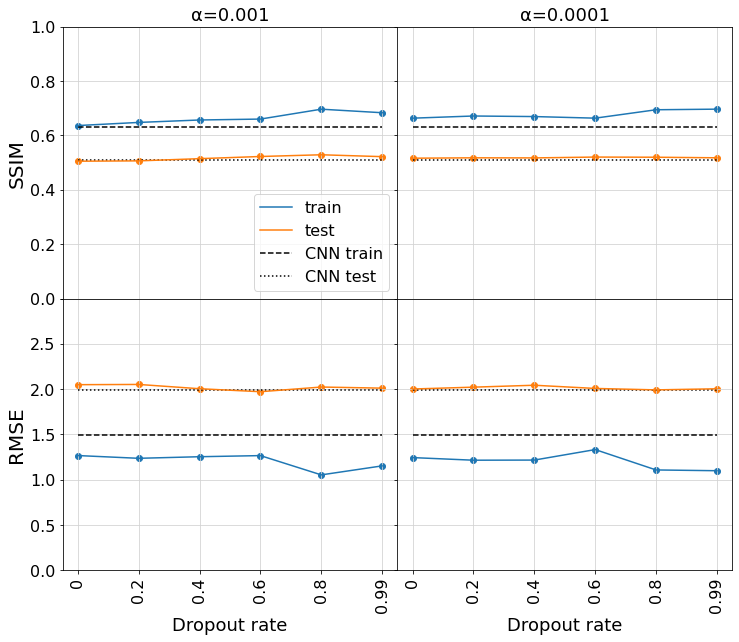

In [1197]:
fig, (axs1,axs) = plt.subplots(2,2,figsize = (12,10),sharex=True, sharey='row')


alphas = [0.001, 0.0001]
dropout_rates = [0,0.2, 0.4, 0.6, 0.8,0.99]

a_id = 0
for a in alphas:
    train_rms = []
    test_rms = []
    train_ssim = []
    test_ssim = []

    d_id = 0
    for d in dropout_rates:
        perf_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/temperature/LR_MR_grid_search/'+'alpha' + str(a) + '_dropout' + str(d)+'/performance_df.csv')
        
        train_rms.append(min(perf_df['rms_train']))    
        test_rms.append(min(perf_df['rms_test']))
        train_ssim.append(max(perf_df['SSIM_train']))    
        test_ssim.append(max(perf_df['SSIM_test']))
        
        d_id += 1
    axs[a_id].grid(color='lightgray')
    axs[a_id].scatter(range(6),train_rms)
    axs[a_id].scatter(range(6),test_rms)
    axs[a_id].plot(range(6),train_rms, label='train')
    axs[a_id].plot(range(6),test_rms, label='test')
    axs[a_id].set_ylim(0,3)

    axs[a_id].set_xlabel('Dropout rate', fontsize=fs-2)
    
    
    axs[a_id].hlines(T_lr_mr_performance_df['rms_train'][36],0,5,linestyles='dashed', label='CNN train')
    axs[a_id].hlines(T_lr_mr_performance_df['rms_test'][36],0,5,linestyles='dotted', label='CNN test')
    
    axs[a_id].set_yticklabels(np.arange(0,3,0.5))
    
    axs[a_id].tick_params(axis='both', labelsize=fs-4)
    axs[a_id].set_xticks(range(6))
    axs[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    axs1[a_id].grid(color='lightgray')
    axs1[a_id].scatter(range(6),train_ssim)
    axs1[a_id].scatter(range(6),test_ssim)
    axs1[a_id].plot(range(6),train_ssim, label='train')
    axs1[a_id].plot(range(6),test_ssim, label='test')
    axs1[a_id].set_ylim(0,1)
    
    
    axs1[a_id].hlines(T_lr_mr_performance_df['SSIM_train'][36],0,5,linestyles='dashed', label='CNN train')
    axs1[a_id].hlines(T_lr_mr_performance_df['SSIM_test'][36],0,5,linestyles='dotted', label='CNN test')
    
    axs1[a_id].tick_params(axis='both', labelsize=fs-4)
    axs1[a_id].set_xticks(range(6))
    axs1[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    
    axs1[a_id].set_title('\u03B1='+str(a), fontsize=fs-2)
    
    a_id += 1
    
axs[0].set_ylabel('RMSE', fontsize=fs)
axs1[0].set_ylabel('SSIM', fontsize=fs)

axs1[0].legend(loc='lower right',fontsize=fs-4)

fig.subplots_adjust(hspace=0.,wspace=0)

plt.show()
fig.savefig('figures/results/lr_mr/grid_search_T2m.pdf', bbox_inches = 'tight')

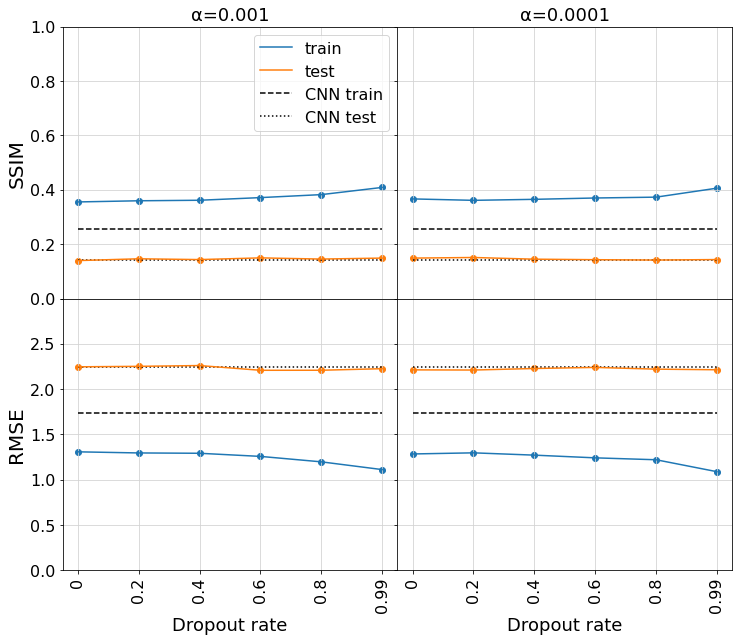

In [1198]:
fig, (axs1,axs) = plt.subplots(2,2,figsize = (12,10),sharex=True, sharey='row')


alphas = [0.001, 0.0001]
dropout_rates = [0,0.2, 0.4, 0.6, 0.8,0.99]

a_id = 0
for a in alphas:
    train_rms = []
    test_rms = []
    train_ssim = []
    test_ssim = []

    d_id = 0
    for d in dropout_rates:
        perf_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR_grid_search/'+'alpha' + str(a) + '_dropout' + str(d)+'/performance_df_1.csv')
        
        train_rms.append(min(perf_df['rms_train']))    
        test_rms.append(min(perf_df['rms_test']))
        train_ssim.append(max(perf_df['SSIM_train']))    
        test_ssim.append(max(perf_df['SSIM_test']))
        
        d_id += 1
    axs[a_id].grid(color='lightgray')
    axs[a_id].scatter(range(6),train_rms)
    axs[a_id].scatter(range(6),test_rms)
    axs[a_id].plot(range(6),train_rms, label='train')
    axs[a_id].plot(range(6),test_rms, label='test')
    axs[a_id].set_ylim(0,3)

    axs[a_id].set_xlabel('Dropout rate', fontsize=fs-2)
    
    
    axs[a_id].hlines(V_lr_mr_performance_df['rms_train'][6],0,5,linestyles='dashed', label='CNN train')
    axs[a_id].hlines(V_lr_mr_performance_df['rms_test'][6],0,5,linestyles='dotted', label='CNN test')
    
    axs[a_id].set_yticklabels(np.arange(0,3,0.5))
    
    axs[a_id].tick_params(axis='both', labelsize=fs-4)
    axs[a_id].set_xticks(range(6))
    axs[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    axs1[a_id].grid(color='lightgray')
    axs1[a_id].scatter(range(6),train_ssim)
    axs1[a_id].scatter(range(6),test_ssim)
    axs1[a_id].plot(range(6),train_ssim, label='train')
    axs1[a_id].plot(range(6),test_ssim, label='test')
    axs1[a_id].set_ylim(0,1)
    
    
    axs1[a_id].hlines(V_lr_mr_performance_df['SSIM_train'][6],0,5,linestyles='dashed', label='CNN train')
    axs1[a_id].hlines(V_lr_mr_performance_df['SSIM_test'][6],0,5,linestyles='dotted', label='CNN test')
    
    axs1[a_id].tick_params(axis='both', labelsize=fs-4)
    axs1[a_id].set_xticks(range(6))
    axs1[a_id].set_xticklabels(dropout_rates,rotation=90)
    
    
    axs1[a_id].set_title('\u03B1='+str(a), fontsize=fs-2)
    
    a_id += 1
    
axs[0].set_ylabel('RMSE', fontsize=fs)
axs1[0].set_ylabel('SSIM', fontsize=fs)

axs1[0].legend(loc='upper right',fontsize=fs-4)

fig.subplots_adjust(hspace=0.,wspace=0)

plt.show()
fig.savefig('figures/results/lr_mr/grid_search_V10m.pdf', bbox_inches = 'tight')

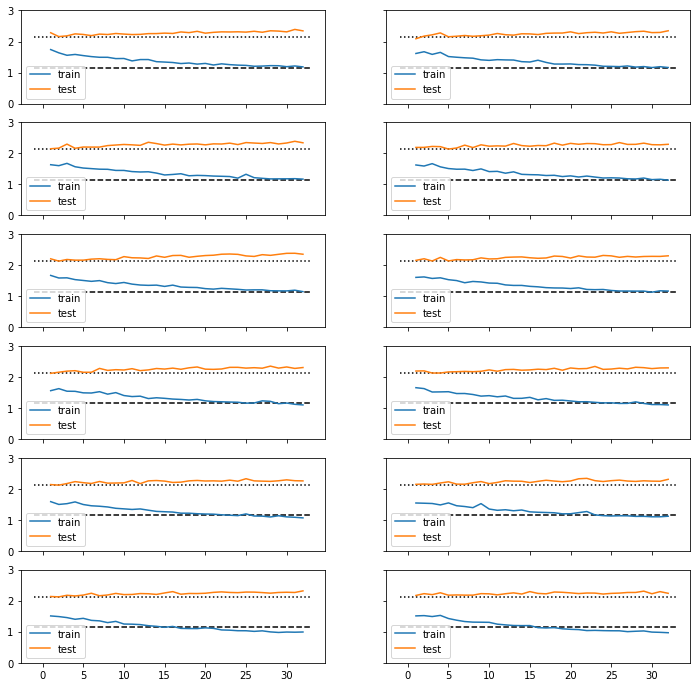

In [1048]:
fig, axs = plt.subplots(6,2,figsize = (12,12),sharex=True, sharey=True)

d_id = 0
for d in dropout_rates:
    a_id = 0
    for a in alphas:
        #print(d_id, a_id)
        perf_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/LR_MR_grid_search/'+'alpha' + str(a) + '_dropout' + str(d)+'/performance_df.csv')
        axs[d_id, a_id].plot(perf_df['Epoch'], perf_df['rms_train'], label='train')
        axs[d_id, a_id].plot(perf_df['Epoch'], perf_df['rms_test'], label='test')
        axs[d_id, a_id].legend()
        axs[d_id, a_id].set_ylim(0,3)
        axs[d_id, a_id].hlines(min(U_lr_mr_performance_df['rms_train']),-1,33,linestyles='dashed', label='CNN train')
        axs[d_id, a_id].hlines(min(U_lr_mr_performance_df['rms_test']),-1,33,linestyles='dotted', label='CNN test')

        a_id += 1
    d_id += 1

plt.show()

### MR to HR models

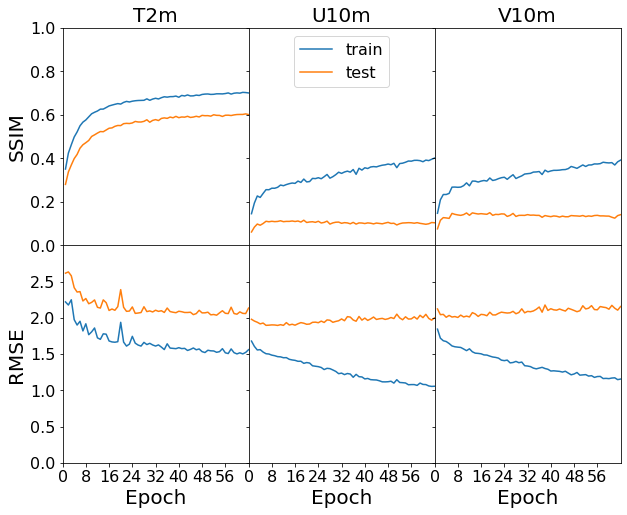

In [1207]:
T_mr_hr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/temperature/MR_HR'+'/performance_df_0.csv')
U_mr_hr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/MR_HR'+'/performance_df_0.csv')
V_mr_hr_performance_df = pd.read_csv('G:/Mijn Drive/Studie/thesis/data_out/wind/MR_HR'+'/performance_df_1.csv')

fig, [axs1,axs2] = plt.subplots(2,3,figsize = (10,8), sharex=True, sharey = 'row')


for ax, r,title in zip(axs1.flat, 
                                       [T_mr_hr_performance_df, U_mr_hr_performance_df,V_mr_hr_performance_df],
                                       ['T2m','U10m','V10m']):
    # SSIM
    ax.plot(r['Epoch'], +r['SSIM_train'], label='train')
    ax.plot(r['Epoch'], r['SSIM_test'], label='test')

    #ax.hlines(np.mean(base),-3,100,linestyles='dashed', label='Baseline')
    #ax.hlines(np.mean(control),-1,64,linestyles='dotted', label='Control')
    
    ax.set_title(title,fontsize=fs)

axs1[0].set_ylim(0, 1)
axs1[0].set_xlim(0,64)

axs1[0].set_ylabel('SSIM', fontsize = fs)
axs1[0].tick_params(axis='both', labelsize=fs-4)

axs1[1].legend(loc ='upper center', fontsize = fs-4)



# RMSE

for ax, r in zip(axs2.flat, 
                       [T_mr_hr_performance_df, U_mr_hr_performance_df, V_mr_hr_performance_df]):

    ax.plot(r['Epoch'], r['rms_train'], label='train')
    ax.plot(r['Epoch'], r['rms_test'], label='test')

    ax.set_ylim(0,3)
    #ax.hlines(np.mean(base),-1,64,linestyles='dashed', label='NCEP 18km')
    #ax.hlines(np.mean(control),-1,64,linestyles='dotted', label='Bicubic interpolation')
    
    ax.set_xlabel('Epoch', fontsize = fs)
    ax.set_xlim(0,64)


    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks(np.arange(0,64,8))
    ax.set_xticklabels(np.arange(0,72,8))

    ax.set_yticks(np.arange(0,3,0.5))
    ax.set_yticklabels(np.arange(0,3,0.5))
    
axs2[0].set_ylabel('RMSE', fontsize = fs)


plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
plt.show()

fig.savefig('figures/results/mr_hr/epoch.pdf',bbox_inches='tight')

#### MAPS and time

In [3]:
temp_mr_hr_SR_train = np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/MR_HR/train/cnn00037/dataSR.npy')[:,:,:,0]
temp_mr_hr_SR_test = np.load('G:/Mijn Drive/Studie/thesis/data_out/temperature/MR_HR/test/cnn00037/dataSR.npy')[:,:,:,0]

Wind_SR_train = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/MR_HR/train/cnn00007/dataSR.npy')
Wind_SR_test = np.load('G:/Mijn Drive/Studie/thesis/data_out/wind/MR_HR/test/cnn00007/dataSR.npy')

In [4]:
U_mr_hr_train = Wind_SR_train[:,:,:,0]
U_mr_hr_test = Wind_SR_test[:,:,:,0]

V_mr_hr_train = Wind_SR_train[:,:,:,1]
V_mr_hr_test = Wind_SR_test[:,:,:,1]

In [1179]:
# map
T_mr_hr_rms_train_map, T_mr_hr_ssim_train_map = hf.performance_map(temp_mr_hr_SR_train,T_WRF_3km)
T_mr_hr_rms_test_map, T_mr_hr_ssim_test_map = hf.performance_map(temp_mr_hr_SR_test,T_WRF_3km_test)

U_mr_hr_rms_train_map, U_mr_hr_ssim_train_map = hf.performance_map(U_mr_hr_train,U_WRF_3km)
U_mr_hr_rms_test_map, U_mr_hr_ssim_test_map = hf.performance_map(U_mr_hr_test,U_WRF_3km_test)

V_mr_hr_rms_train_map, V_mr_hr_ssim_train_map = hf.performance_map(V_mr_hr_train,V_WRF_3km)
V_mr_hr_rms_test_map, V_mr_hr_ssim_test_map = hf.performance_map(V_mr_hr_test,V_WRF_3km_test)

# time
T_mr_hr_rms_train, T_mr_hr_ssim_train = hf.performance_time(temp_lr_mr_SR_train,T_WRF_3km)
T_mr_hr_rms_test, T_mr_hr_ssim_test = hf.performance_time(temp_lr_mr_SR_test,T_WRF_3km_test)

U_mr_hr_rms_train, U_mr_hr_ssim_train = hf.performance_time(U_mr_hr_train,U_WRF_3km)
U_mr_hr_rms_test, U_mr_hr_ssim_test = hf.performance_time(U_mr_hr_test,U_WRF_3km_test)

V_mr_hr_rms_train, V_mr_hr_ssim_train = hf.performance_time(V_mr_hr_train,V_WRF_3km)
V_mr_hr_rms_test, V_mr_hr_ssim_test = hf.performance_time(V_mr_hr_test,V_WRF_3km_test)

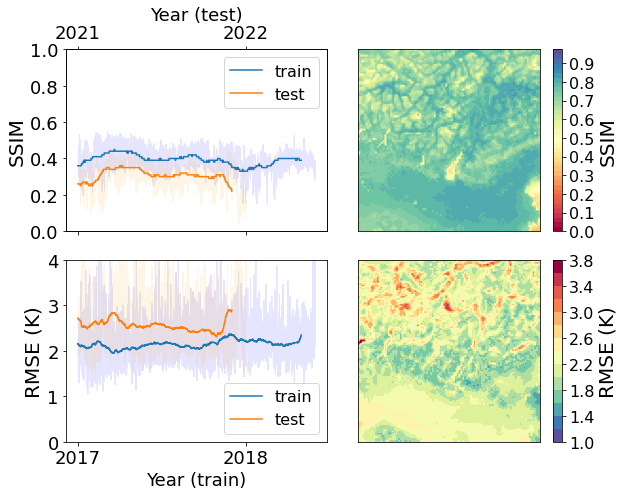

In [1226]:
S_bounds = np.arange(0,1,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(1,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(T_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(T_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),T_mr_hr_ssim_train, T_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(T_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),T_mr_hr_ssim_test, T_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(T_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (K)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(T_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), T_mr_hr_rms_train, T_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(T_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), T_mr_hr_rms_test, T_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (K)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/mr_hr/space_time_T2m.pdf',bbox_inches='tight')

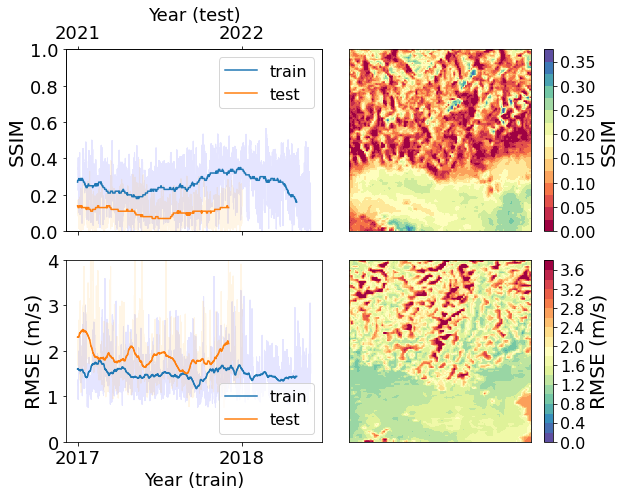

In [1228]:
S_bounds = np.arange(0,0.4,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(0,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(U_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(U_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),U_mr_hr_ssim_train, U_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(U_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),U_mr_hr_ssim_test, U_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(U_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (m/s)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(U_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), U_mr_hr_rms_train, U_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(U_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), U_mr_hr_rms_test, U_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (m/s)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/mr_hr/space_time_U10m.pdf',bbox_inches='tight')

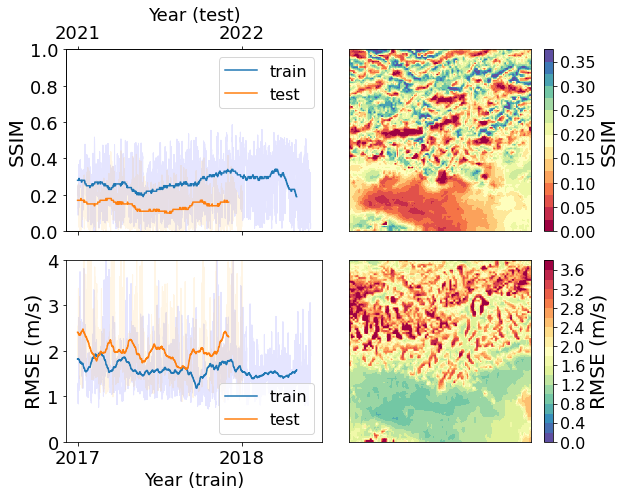

In [1229]:
S_bounds = np.arange(0,0.4,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(0,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(V_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(V_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(4128),V_mr_hr_ssim_train, V_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(V_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),V_mr_hr_ssim_test, V_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-2)
ax2.set_xticks([0,2920])
ax2.set_xticklabels(labels=['2017','2018'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2021','2022'])




im = ax4.imshow(np.flipud(V_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (m/s)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(V_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(4128), V_mr_hr_rms_train, V_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(V_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), V_mr_hr_rms_test, V_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (m/s)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-2)
ax5.set_xticks([0,2920])
ax5.set_xticklabels(labels=['2017','2018'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('figures/results/mr_hr/space_time_V10m.pdf',bbox_inches='tight')

2021-12-28 00:00:00


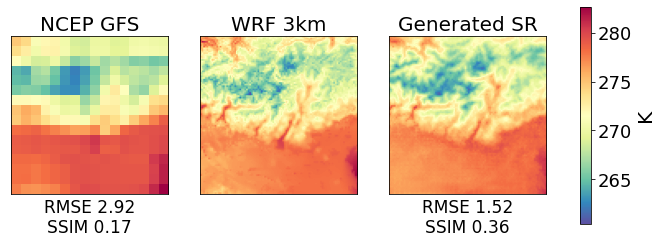

2021-02-11 15:00:00


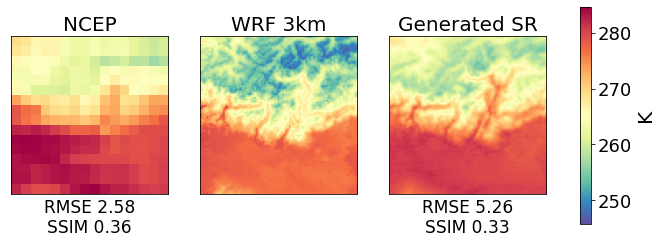

In [1268]:
# BEST
t = T_mr_hr_rms_test.index(min(T_mr_hr_rms_test))

print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [T_NCEP_test[t,:,:,0],T_WRF_3km_test[t,:,:], temp_mr_hr_SR_test[t]],
                         ['NCEP GFS','WRF 3km','Generated SR'],
                         [(T_rms_NCEP_downv3km[t],T_ssim_NCEP_downv3km[t]),'' ,(T_mr_hr_rms_test[t], T_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(T_NCEP_test[t,:,:,0]),np.min(T_WRF_3km_test[t,:,:]), np.min(temp_mr_hr_SR_test[t])]), 
                   vmax=max([np.max(T_NCEP_test[t,:,:,0]),np.max(T_WRF_3km_test[t,:,:]), np.max(temp_mr_hr_SR_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='K', fontsize = fs)

plt.show()
fig.savefig('figures/results/mr_hr/best_SR_T2m.pdf', bbox_inches = 'tight')





# WORST
t = T_mr_hr_rms_test.index(max(T_mr_hr_rms_test))
print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [T_NCEP_test[t,:,:,0],T_WRF_3km_test[t,:,:], temp_mr_hr_SR_test[t]],
                         ['NCEP','WRF 3km','Generated SR'],
                         [(T_rms_NCEP_downv9km[t],T_ssim_NCEP_downv9km[t]),'' ,(T_mr_hr_rms_test[t], T_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(T_NCEP_test[t,:,:,0]),np.min(T_WRF_3km_test[t,:,:]), np.min(temp_mr_hr_SR_test[t])]), 
                   vmax=max([np.max(T_NCEP_test[t,:,:,0]),np.max(T_WRF_3km_test[t,:,:]), np.max(temp_mr_hr_SR_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='K', fontsize = fs)

plt.show()

fig.savefig('figures/results/mr_hr/worst_SR_T2m.pdf', bbox_inches = 'tight')

2021-11-20 12:00:00


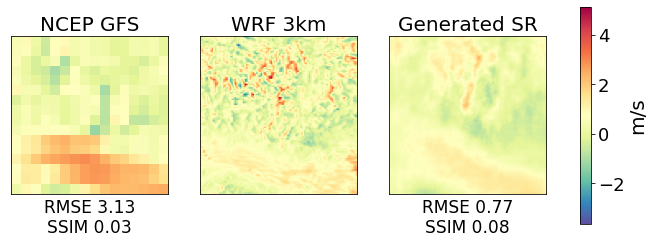

222
2021-01-28 18:00:00


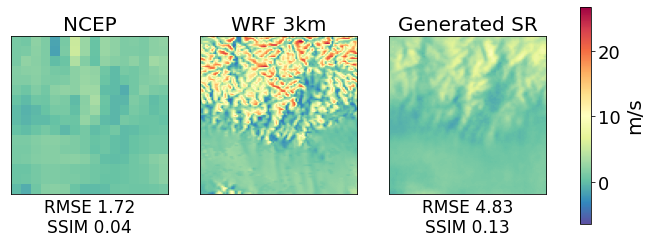

In [1269]:
# BEST
t = U_mr_hr_rms_test.index(min(U_mr_hr_rms_test))

print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [U_NCEP_test[t,:,:,0],U_WRF_3km_test[t,:,:], U_mr_hr_test[t]],
                         ['NCEP GFS','WRF 3km','Generated SR'],
                         [(U_rms_NCEP_downv3km[t],U_ssim_NCEP_downv3km[t]),'' ,(U_mr_hr_rms_test[t], U_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(U_NCEP_test[t,:,:,0]),np.min(U_WRF_3km_test[t,:,:]), np.min(U_mr_hr_test[t])]), 
                   vmax=max([np.max(U_NCEP_test[t,:,:,0]),np.max(U_WRF_3km_test[t,:,:]), np.max(U_mr_hr_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()
fig.savefig('figures/results/mr_hr/best_SR_U10m.pdf', bbox_inches = 'tight')





# WORST
t = U_mr_hr_rms_test.index(max(U_mr_hr_rms_test))
print(t)
print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [U_NCEP_test[t,:,:,0],U_WRF_3km_test[t,:,:], U_mr_hr_test[t]],
                         ['NCEP','WRF 3km','Generated SR'],
                         [(U_rms_NCEP_downv9km[t],U_ssim_NCEP_downv9km[t]),'' ,(U_mr_hr_rms_test[t], U_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(U_NCEP_test[t,:,:,0]),np.min(U_WRF_3km_test[t,:,:]), np.min(U_mr_hr_test[t])]), 
                   vmax=max([np.max(U_NCEP_test[t,:,:,0]),np.max(U_WRF_3km_test[t,:,:]), np.max(U_mr_hr_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('figures/results/mr_hr/worst_SR_U10m.pdf', bbox_inches = 'tight')

2021-08-20 06:00:00


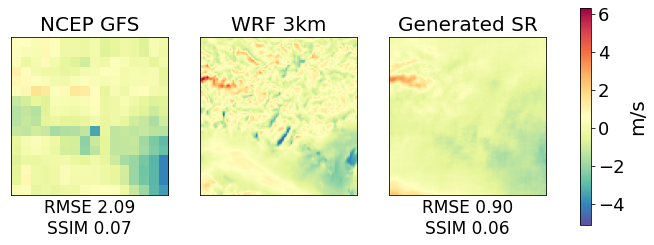

1140
2021-05-23 12:00:00


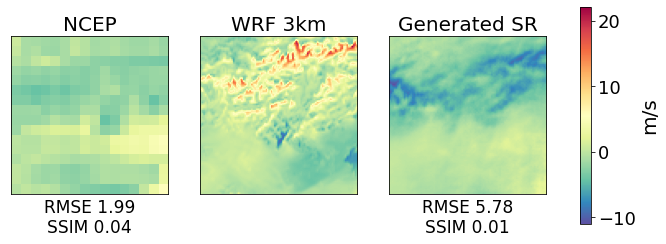

In [1270]:
# BEST
t = V_mr_hr_rms_test.index(min(V_mr_hr_rms_test))

print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [V_NCEP_test[t,:,:,0],V_WRF_3km_test[t,:,:], V_mr_hr_test[t]],
                         ['NCEP GFS','WRF 3km','Generated SR'],
                         [(V_rms_NCEP_downv3km[t],V_ssim_NCEP_downv3km[t]),'' ,(V_mr_hr_rms_test[t], V_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(V_NCEP_test[t,:,:,0]),np.min(V_WRF_3km_test[t,:,:]), np.min(V_mr_hr_test[t])]), 
                   vmax=max([np.max(V_NCEP_test[t,:,:,0]),np.max(V_WRF_3km_test[t,:,:]), np.max(V_mr_hr_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()
fig.savefig('figures/results/mr_hr/best_SR_V10m.pdf', bbox_inches = 'tight')





# WORST
t = V_mr_hr_rms_test.index(max(V_mr_hr_rms_test))
print(t)
print(index_to_datetime(t,2021))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [V_NCEP_test[t,:,:,0],V_WRF_3km_test[t,:,:], V_mr_hr_test[t]],
                         ['NCEP','WRF 3km','Generated SR'],
                         [(V_rms_NCEP_downv9km[t],V_ssim_NCEP_downv9km[t]),'' ,(V_mr_hr_rms_test[t], V_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(V_NCEP_test[t,:,:,0]),np.min(V_WRF_3km_test[t,:,:]), np.min(V_mr_hr_test[t])]), 
                   vmax=max([np.max(V_NCEP_test[t,:,:,0]),np.max(V_WRF_3km_test[t,:,:]), np.max(V_mr_hr_test[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 3km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('figures/results/mr_hr/worst_SR_V10m.pdf', bbox_inches = 'tight')

### LR, MR, HR and SR

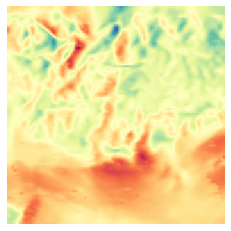

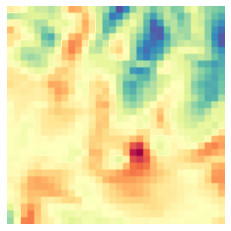

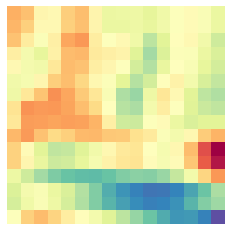

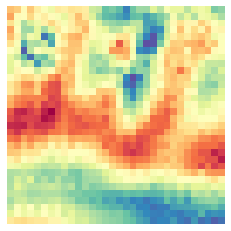

In [1117]:
#t = 560
t = 666

fig = plt.figure()
plt.imshow(np.flipud(U_WRF_3km[t]),cmap='Spectral')
plt.axis('off')
plt.show()
fig.savefig('figures/HR.pdf',bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.flipud(U_WRF_9km[t]),cmap='Spectral')
plt.axis('off')
plt.show()
fig.savefig('figures/MR.pdf',bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.flipud(U_NCEP_down[t]), cmap='Spectral')
plt.axis('off')
plt.show()
fig.savefig('figures/LR.pdf',bbox_inches='tight')

fig = plt.figure()
plt.imshow(np.flipud(Wind_SR_train[t,:,:,0]), cmap='Spectral')
plt.axis('off')
plt.show()
fig.savefig('figures/SR.pdf',bbox_inches='tight')

### Minmax trial

In [ ]:
from helper_functions import minmax_norm, rescale

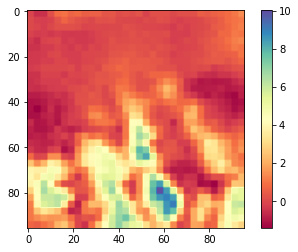

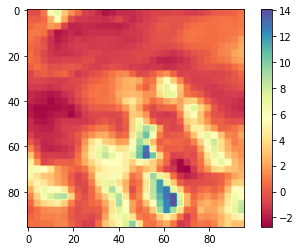

In [ ]:
t = 7

plt.imshow(rescale(regrid(test[t:t+1,:,:,0],3)[0],np.max(U_WRF_9km),np.min(U_WRF_9km)), cmap = 'Spectral')
plt.colorbar()
plt.show()

plt.imshow(split[t,:,:], cmap = 'Spectral')
plt.colorbar()
plt.show()


r = rescale(regrid(test[:,:,:,0],3),np.max(U_WRF_9km),np.min(U_WRF_9km))

In [ ]:
A = rescale(minmax_norm(U_WRF_9km_test),np.max(U_WRF_9km_test),np.min(U_WRF_9km_test))

rms(A[7],U_WRF_9km_test[7])

8.114257e-07

### Lake Garda results (final result)
TODO
- data to be plotted/calculated to .nc or .tiff
 should be only aggregated data:
    - RMSE over lake Garda
    - 

In [10]:
import rasterio
rst = rasterio.open("C:/Users/SWFva/OneDrive/Documents/Studie/Thesis/visualization/data/Lake Garda rasterized.tif")

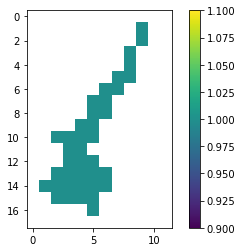

In [37]:
Lake_mask = np.array(rst.read(1), dtype='float')

Lake_mask[Lake_mask == 0] = np.nan # or use np.nan

Lake_mask = Lake_mask[53:71,45:57]

plt.imshow(Lake_mask)
plt.colorbar()
plt.show()

In [38]:
Lake_mask.shape

(18, 12)

In [102]:
# train
T_NCEP_masked = np.flipud(T_NCEP_near)[:,53:71,45:57]*Lake_mask
T_WRF_masked = np.flipud(T_WRF_3km)[:,53:71,45:57]*Lake_mask
T_SR_masked = np.flipud(temp_mr_hr_SR_train)[:,53:71,45:57]*Lake_mask

U_NCEP_masked = np.flipud(U_NCEP_near)[:,53:71,45:57]*Lake_mask
U_WRF_masked = np.flipud(U_WRF_3km)[:,53:71,45:57]*Lake_mask
U_SR_masked = np.flipud(U_mr_hr_train)[:,53:71,45:57]*Lake_mask

V_NCEP_masked = np.flipud(V_NCEP_near)[:,53:71,45:57]*Lake_mask
V_WRF_masked = np.flipud(V_WRF_3km)[:,53:71,45:57]*Lake_mask
V_SR_masked = np.flipud(V_mr_hr_train)[:,53:71,45:57]*Lake_mask

# test
T_NCEP_test_masked = np.flipud(hf.regrid(T_NCEP_test,6))[:,53:71,45:57]*Lake_mask
T_WRF_test_masked = np.flipud(T_WRF_3km_test)[:,53:71,45:57]*Lake_mask
T_SR_test_masked = np.flipud(temp_mr_hr_SR_test)[:,53:71,45:57]*Lake_mask

U_NCEP_test_masked = np.flipud(hf.regrid(U_NCEP_test,6))[:,53:71,45:57]*Lake_mask
U_WRF_test_masked = np.flipud(U_WRF_3km_test)[:,53:71,45:57]*Lake_mask
U_SR_test_masked = np.flipud(U_mr_hr_test)[:,53:71,45:57]*Lake_mask

V_NCEP_test_masked = np.flipud(hf.regrid(V_NCEP_test,6))[:,53:71,45:57]*Lake_mask
V_WRF_test_masked = np.flipud(V_WRF_3km_test)[:,53:71,45:57]*Lake_mask
V_SR_test_masked = np.flipud(V_mr_hr_test)[:,53:71,45:57]*Lake_mask

In [109]:
# train
T_NCEP_mask_vals = [[],[],[]] # min, mean, max
T_WRF_mask_vals = [[],[],[]] # min, mean, max
T_SR_mask_vals = [[],[],[]] # min, mean, max

U_NCEP_mask_vals = [[],[],[]] # min, mean, max
U_WRF_mask_vals = [[],[],[]] # min, mean, max
U_SR_mask_vals = [[],[],[]] # min, mean, max

V_NCEP_mask_vals = [[],[],[]] # min, mean, max
V_WRF_mask_vals = [[],[],[]] # min, mean, max
V_SR_mask_vals = [[],[],[]] # min, mean, max

# test
T_NCEP_test_mask_vals = [[],[],[]] # min, mean, max
T_WRF_test_mask_vals = [[],[],[]] # min, mean, max
T_SR_test_mask_vals = [[],[],[]] # min, mean, max

U_NCEP_test_mask_vals = [[],[],[]] # min, mean, max
U_WRF_test_mask_vals = [[],[],[]] # min, mean, max
U_SR_test_mask_vals = [[],[],[]] # min, mean, max

V_NCEP_test_mask_vals = [[],[],[]] # min, mean, max
V_WRF_test_mask_vals = [[],[],[]] # min, mean, max
V_SR_test_mask_vals = [[],[],[]] # min, mean, max

for i in range(240): 
    # train
    # T
    T_NCEP_mask_vals[0].append(np.nanmin(T_NCEP_masked[i]))
    T_NCEP_mask_vals[1].append(np.nanmean(T_NCEP_masked[i]))
    T_NCEP_mask_vals[2].append(np.nanmax(T_NCEP_masked[i]))
    
    T_WRF_mask_vals[0].append(np.nanmin(T_WRF_masked[i]))
    T_WRF_mask_vals[1].append(np.nanmean(T_WRF_masked[i]))
    T_WRF_mask_vals[2].append(np.nanmax(T_WRF_masked[i]))
    
    T_SR_mask_vals[0].append(np.nanmin(T_SR_masked[i]))
    T_SR_mask_vals[1].append(np.nanmean(T_SR_masked[i]))
    T_SR_mask_vals[2].append(np.nanmax(T_SR_masked[i]))
    
    # U
    U_NCEP_mask_vals[0].append(np.nanmin(U_NCEP_masked[i]))
    U_NCEP_mask_vals[1].append(np.nanmean(U_NCEP_masked[i]))
    U_NCEP_mask_vals[2].append(np.nanmax(U_NCEP_masked[i]))
    
    U_WRF_mask_vals[0].append(np.nanmin(U_WRF_masked[i]))
    U_WRF_mask_vals[1].append(np.nanmean(U_WRF_masked[i]))
    U_WRF_mask_vals[2].append(np.nanmax(U_WRF_masked[i]))
    
    U_SR_mask_vals[0].append(np.nanmin(U_SR_masked[i]))
    U_SR_mask_vals[1].append(np.nanmean(U_SR_masked[i]))
    U_SR_mask_vals[2].append(np.nanmax(U_SR_masked[i]))
    
    # V
    V_NCEP_mask_vals[0].append(np.nanmin(V_NCEP_masked[i]))
    V_NCEP_mask_vals[1].append(np.nanmean(V_NCEP_masked[i]))
    V_NCEP_mask_vals[2].append(np.nanmax(V_NCEP_masked[i]))
    
    V_WRF_mask_vals[0].append(np.nanmin(V_WRF_masked[i]))
    V_WRF_mask_vals[1].append(np.nanmean(V_WRF_masked[i]))
    V_WRF_mask_vals[2].append(np.nanmax(V_WRF_masked[i]))
    
    V_SR_mask_vals[0].append(np.nanmin(V_SR_masked[i]))
    V_SR_mask_vals[1].append(np.nanmean(V_SR_masked[i]))
    V_SR_mask_vals[2].append(np.nanmax(V_SR_masked[i]))
    
    # test
    # T
    T_NCEP_test_mask_vals[0].append(np.nanmin(T_NCEP_test_masked[i]))
    T_NCEP_test_mask_vals[1].append(np.nanmean(T_NCEP_test_masked[i]))
    T_NCEP_test_mask_vals[2].append(np.nanmax(T_NCEP_test_masked[i]))
    
    T_WRF_test_mask_vals[0].append(np.nanmin(T_WRF_test_masked[i]))
    T_WRF_test_mask_vals[1].append(np.nanmean(T_WRF_test_masked[i]))
    T_WRF_test_mask_vals[2].append(np.nanmax(T_WRF_test_masked[i]))
    
    T_SR_test_mask_vals[0].append(np.nanmin(T_SR_test_masked[i]))
    T_SR_test_mask_vals[1].append(np.nanmean(T_SR_test_masked[i]))
    T_SR_test_mask_vals[2].append(np.nanmax(T_SR_test_masked[i]))
    
    # U
    U_NCEP_test_mask_vals[0].append(np.nanmin(U_NCEP_test_masked[i]))
    U_NCEP_test_mask_vals[1].append(np.nanmean(U_NCEP_test_masked[i]))
    U_NCEP_test_mask_vals[2].append(np.nanmax(U_NCEP_test_masked[i]))
    
    U_WRF_test_mask_vals[0].append(np.nanmin(U_WRF_test_masked[i]))
    U_WRF_test_mask_vals[1].append(np.nanmean(U_WRF_test_masked[i]))
    U_WRF_test_mask_vals[2].append(np.nanmax(U_WRF_test_masked[i]))
    
    U_SR_test_mask_vals[0].append(np.nanmin(U_SR_test_masked[i]))
    U_SR_test_mask_vals[1].append(np.nanmean(U_SR_test_masked[i]))
    U_SR_test_mask_vals[2].append(np.nanmax(U_SR_test_masked[i]))
    
    # V
    V_NCEP_test_mask_vals[0].append(np.nanmin(V_NCEP_test_masked[i]))
    V_NCEP_test_mask_vals[1].append(np.nanmean(V_NCEP_test_masked[i]))
    V_NCEP_test_mask_vals[2].append(np.nanmax(V_NCEP_test_masked[i]))
    
    V_WRF_test_mask_vals[0].append(np.nanmin(V_WRF_test_masked[i]))
    V_WRF_test_mask_vals[1].append(np.nanmean(V_WRF_test_masked[i]))
    V_WRF_test_mask_vals[2].append(np.nanmax(V_WRF_test_masked[i]))
    
    V_SR_test_mask_vals[0].append(np.nanmin(V_SR_test_masked[i]))
    V_SR_test_mask_vals[1].append(np.nanmean(V_SR_test_masked[i]))
    V_SR_test_mask_vals[2].append(np.nanmax(V_SR_test_masked[i]))
    

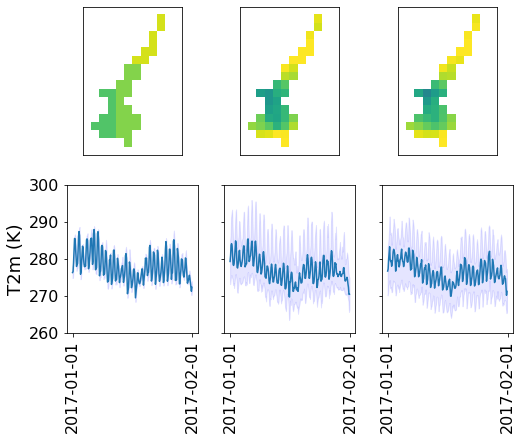

In [249]:
t = 200

fig, (axs1,axs2) = plt.subplots(2,3,figsize = (8,6), sharey='row')

for ax, r, title in zip(axs1.flat,
                              [T_NCEP_masked,T_WRF_masked,T_SR_masked],
                              ['NCEP GFS','WRF 3km', 'Generated SR']):
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(r[t],vmin=260,vmax=280)
    
    
    

for ax, r  in zip(axs2.flat,
                         [T_NCEP_mask_vals,T_WRF_mask_vals,T_SR_mask_vals]):
    ax.plot(r[1])
    ax.fill_between(range(240), r[0], r[2], color='b', alpha=.1)

    ax.set_ylim(260,300)
    
    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks([0,240])
    ax.set_xticklabels(labels=['2017-01-01','2017-02-01'], rotation=90)

axs2[0].set_ylabel('T2m (K)', fontsize=fs-2)

plt.show()

fig.savefig('figures/results/mr_hr/Lake_mask_train_T2m.pdf',bbox_inches='tight')

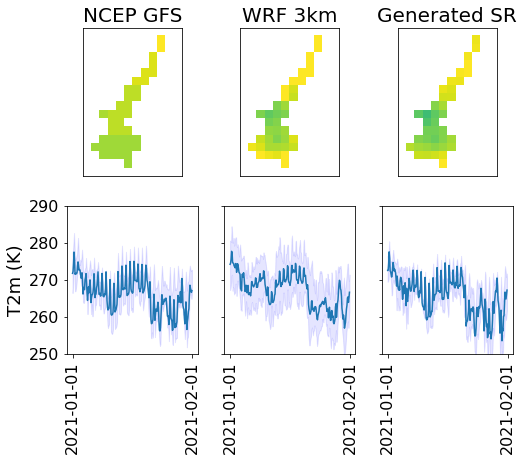

In [248]:
t = 404

fig, (axs1,axs2) = plt.subplots(2,3,figsize = (8,6), sharey='row')

for ax, r, title in zip(axs1.flat,
                              [T_NCEP_test_masked,T_WRF_test_masked,T_SR_test_masked],
                              ['NCEP GFS','WRF 3km', 'Generated SR']):
    ax.imshow(r[t],vmin=250,vmax=280)
    
    
    
    ax.set_title(title, fontsize = fs)
    ax.set_xticks([])
    ax.set_yticks([])

for ax, r  in zip(axs2.flat,
                         [T_NCEP_test_mask_vals,T_WRF_test_mask_vals,T_SR_test_mask_vals]):
    ax.plot(r[1])
    ax.fill_between(range(240), r[0], r[2], color='b', alpha=.1)

    ax.set_ylim(250,290)
    
    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks([0,240])
    ax.set_xticklabels(labels=['2021-01-01','2021-02-01'], rotation=90)

axs2[0].set_ylabel('T2m (K)', fontsize=fs-2)

plt.show()

fig.savefig('figures/results/mr_hr/Lake_mask_test_T2m.pdf',bbox_inches='tight')

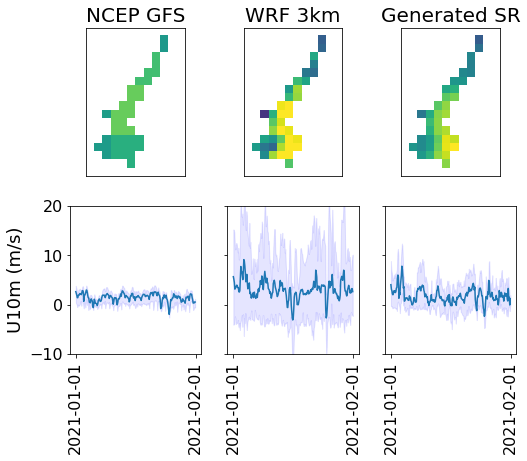

In [230]:
t = 100

fig, (axs1,axs2) = plt.subplots(2,3,figsize = (8,6), sharey='row')

for ax, r, title in zip(axs1.flat,
                              [U_NCEP_test_masked,U_WRF_test_masked,U_SR_test_masked],
                              ['NCEP GFS','WRF 3km', 'Generated SR']):
    ax.imshow(r[t],vmin=-5,vmax=5)
    
    
    ax.set_title(title, fontsize = fs)
    ax.set_xticks([])
    ax.set_yticks([])

for ax, r  in zip(axs2.flat,
                         [U_NCEP_test_mask_vals,U_WRF_test_mask_vals,U_SR_test_mask_vals]):
    ax.plot(r[1])
    ax.fill_between(range(240), r[0], r[2], color='b', alpha=.1)

    ax.set_ylim(-10,20)
    
    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks([0,240])
    ax.set_xticklabels(labels=['2021-01-01','2021-02-01'], rotation=90)

axs2[0].set_ylabel('U10m (m/s)', fontsize=fs-2)

plt.show()

fig.savefig('figures/results/mr_hr/Lake_mask_test_U10m.pdf',bbox_inches='tight')

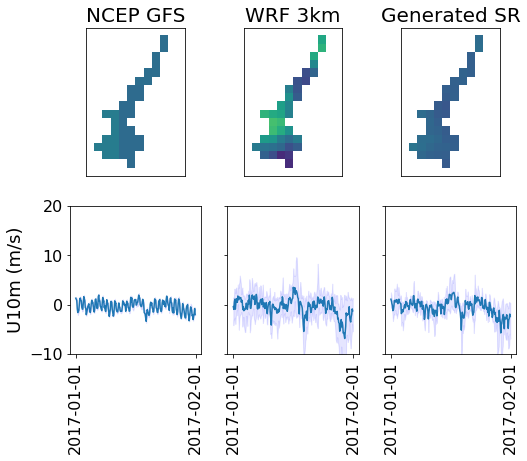

In [227]:
t = 100

fig, (axs1,axs2) = plt.subplots(2,3,figsize = (8,6), sharey='row')

for ax, r, title in zip(axs1.flat,
                              [U_NCEP_masked,U_WRF_masked,U_SR_masked],
                              ['NCEP GFS','WRF 3km', 'Generated SR']):
    ax.imshow(r[t],vmin=-5,vmax=5)
    
    
    ax.set_title(title, fontsize = fs)
    ax.set_xticks([])
    ax.set_yticks([])

for ax, r  in zip(axs2.flat,
                         [U_NCEP_mask_vals,U_WRF_mask_vals,U_SR_mask_vals]):
    ax.plot(r[1])
    ax.fill_between(range(240), r[0], r[2], color='b', alpha=.1)

    ax.set_ylim(-10,20)
    
    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xticks([0,240])
    ax.set_xticklabels(labels=['2017-01-01','2017-02-01'], rotation=90)

axs2[0].set_ylabel('U10m (m/s)', fontsize=fs-2)

plt.show()

fig.savefig('figures/results/mr_hr/Lake_mask_train_U10m.pdf',bbox_inches='tight')

### Make a gif/movie of the time series?

In [252]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(x,label,save_path):
    fig = plt.figure()
    im = plt.imshow(np.flipud(x[0, :, :]),    # display first slice
                    animated=True,
                    cmap='Spectral',               # color mapping
                    vmin=np.min(x), # lowest value in numpy_3d_array
                    vmax=np.max(x)) # highest value in numpy_3d_array
    plt.axis('off')
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=fs)
    cb.set_label(label=label, fontsize = fs)
    plt.tight_layout()

    def init():
        im.set_data(np.flipud(x[0, :, :]))
        return im,

    def animate(i):
        im.set_array(np.flipud(x[i, :, :]))
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(x)[0],  # amount of frames being animated
                                   interval=300,                   
                                   blit=True)
    anim.save(save_path)   # save as gif
    plt.show()

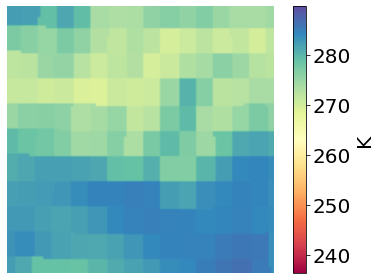

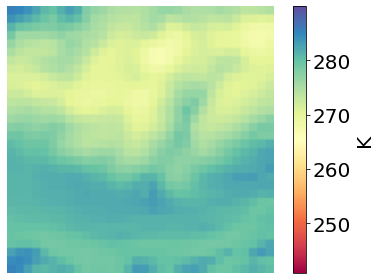

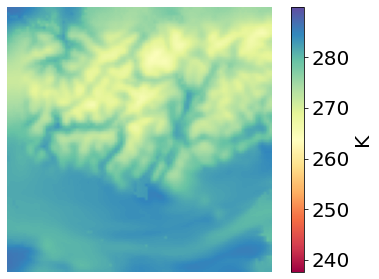

In [253]:
generate_gif(T_NCEP_near[0:500], 'K','figures/movies/T_NCEP.mp4')
generate_gif(T_WRF_9km[0:500], 'K','figures/movies/T_WRF_9km.mp4')
generate_gif(T_WRF_3km[0:500], 'K','figures/movies/T_WRF_3km.mp4')

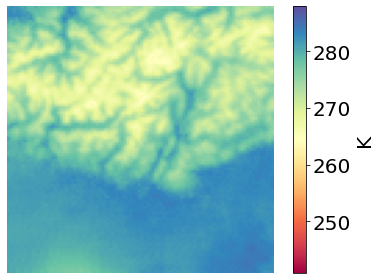

In [255]:
generate_gif(temp_mr_hr_SR_train[0:500], 'K','figures/movies/T_mr_hr_3km.mp4')

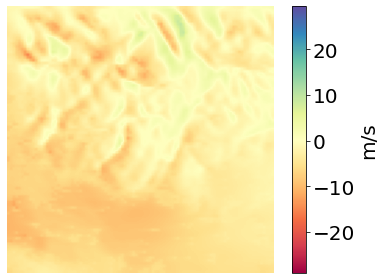

NameError: name 'U_lr_mr_train' is not defined

In [256]:
generate_gif(U_WRF_3km[0:500], 'm/s','figures/movies/U_WRF_3km.mp4')
generate_gif(U_lr_mr_train[0:500], 'm/s','figures/movies/U_mr_hr_3km.mp4')